In [1]:
import anndata as ad
import scanpy as sc
#import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cell2location as c2l
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
adata_scatlas = ad.read_h5ad(os.environ.get('PATH_TO_SCATLAS'))
adata_visium = ad.read_h5ad(os.environ.get('PATH_TO_VISIUM'))

## 1. Data Overview and Pre-processing

In [3]:
print("Number of cells before filtering:", adata_scatlas.n_obs)

Number of cells before filtering: 259721


Remove zero count genes (Korbinian approved)

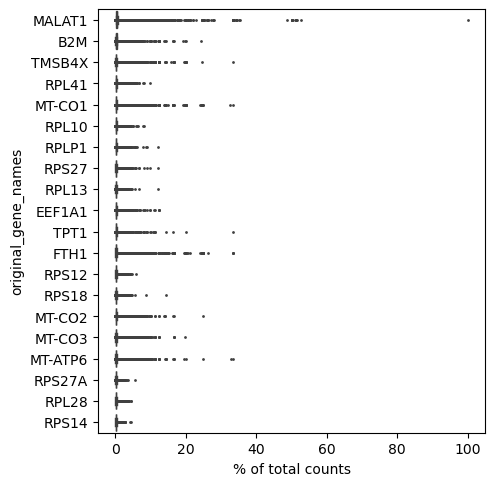

In [4]:
adata_scatlas.var_names = adata_scatlas.var["original_gene_names"]
sc.pp.filter_cells(adata_scatlas, min_counts=1)
sc.pl.highest_expr_genes(adata_scatlas, n_top=20)

In [5]:
print("Number of cells after filtering out zero counts:", adata_scatlas.n_obs)

Number of cells after filtering out zero counts: 259720


Text(0.5, 1.0, 'Distribution of Total Counts')

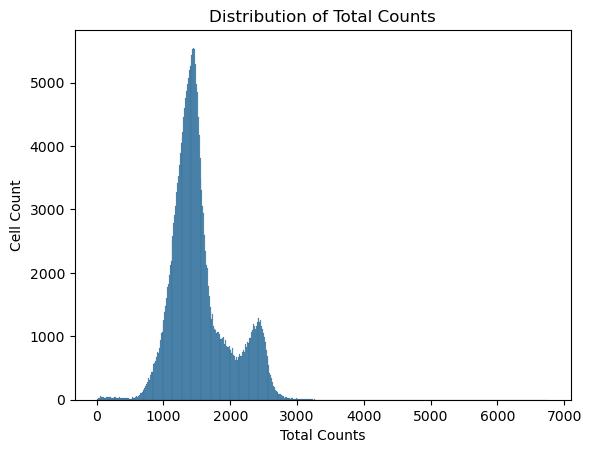

In [6]:
adata_scatlas.obs["total_counts"] = adata_scatlas.X.sum(axis=1)
sns.histplot(adata_scatlas.obs['total_counts'])
plt.xlabel('Total Counts')
plt.ylabel('Cell Count')
plt.title('Distribution of Total Counts')

Ensure the original data was nomalized by reviewing the raw counts

Text(0.5, 1.0, 'Distribution of Raw Total Counts')

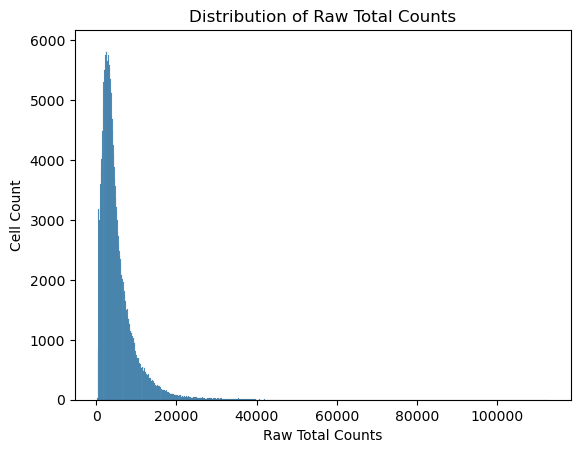

In [7]:
adata_scatlas.obs["total_counts_raw"] = adata_scatlas.raw.X.sum(axis=1)
sns.histplot(adata_scatlas.obs['total_counts_raw'])
plt.xlabel('Raw Total Counts')
plt.ylabel('Cell Count')
plt.title('Distribution of Raw Total Counts')

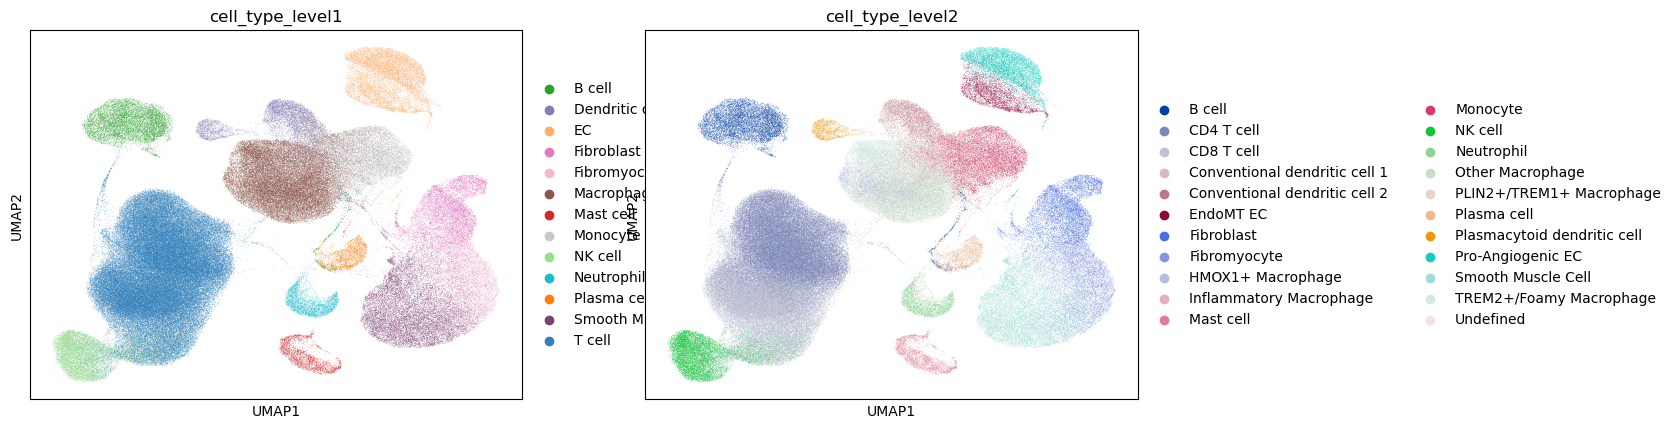

In [8]:
sc.pl.umap(adata_scatlas, color = ["cell_type_level1","cell_type_level2"])

In [9]:
# Remove existing deconvolution results from the Visium data
keys_to_remove = ['means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf']
for key in keys_to_remove:
    if key in adata_visium.obsm:
        del adata_visium.obsm[key]

if 'mod' in adata_visium.uns:
    del adata_visium.uns['mod']

cell_type_columns = [
    'B cells', 'Conventional DC', 'EC, Adjacent (Alsaigh)', 'EC, Artery', 'EC, DKK2 (Atherosclerosis)', 
    'EC, Lymphatic', 'EC, Vasa vasorum', 'Fibroblast', 'Fibroblast (COL9A3+)', 'Macrophages (CD1C+)', 
    'Macrophages (LYVE1+)', 'Macrophages (M4)', 'Macrophages (SPP1+)', 'Macrophages, Developing', 'Macrophages, Foamy', 
    'Macrophages, Inflammatory', 'Macrophages, Proliferating', 'Macrophages, Unknown', 'Mast cells', 'Myofibroblast', 
    'Natural Killer cells', 'Natural Killer cells (Atherosclerosis)', 'Neuron', 'Neutrophils', 'Pericytes', 'Plasma cells', 
    'Plasmacytoid DC', 'T cells (CD8+)', 'T cells, (Mixed CD4/CD8)', 'T cells, CD4+ memmory', 'T cells, CD8+ activated', 
    'T cells, High mitochrondrial reads', 'T cells, Proliferating', 'T cells, regulatory', 'Th1 helper cells (CD4+)', 
    'VSMC', 'VSMC, Osteoblastic'
]

for col in cell_type_columns:
    if col in adata_visium.obs:
        del adata_visium.obs[col]

# 2. Train Model Plaque Atlas Data

In [10]:
# Estimate some cut-off values for filtering
total_genes = adata_scatlas.shape[1]
print(f"Total number of genes: {total_genes}")

# Get the number of cells where each gene has non-zero expression
gene_cell_count = np.sum(adata_scatlas.X > 0, axis=0)

# Count the number of genes with more than 5 cell counts
genes_with_5_cells = np.sum(gene_cell_count > 5)
print(f"Number of genes with more than 5 cell counts: {genes_with_5_cells}")
print(f"Number of cells: {adata_scatlas.shape[0]}")

Total number of genes: 25840
Number of genes with more than 5 cell counts: 25662
Number of cells: 259720


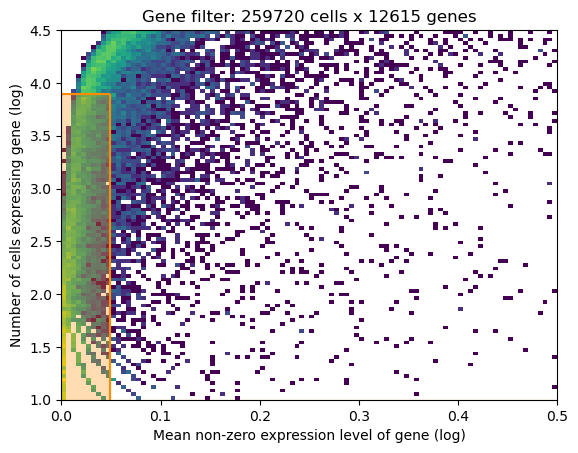

In [11]:
from cell2location.utils.filtering import filter_genes
adata_ref = adata_scatlas.copy()
adata_ref.X = adata_ref.raw.X
selected = filter_genes(adata_ref, cell_count_cutoff=1, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

In [12]:
c2l.models.RegressionModel.setup_anndata(adata=adata_ref,
                        batch_key='donor_id',
                        labels_key='cell_type_level2'
                       )

model1 = c2l.models.RegressionModel(adata=adata_ref,)
model1.view_anndata_setup()

"""
model1.train(max_epochs=250, accelerator="gpu")
"""

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'donor_id',
│   'labels_key': 'cell_type_level2',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   75   │
│         n_cells          │ 259720 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   22   │
│          n_vars          │ 12615  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                        batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor_id'] │ 1_2_3_Slysz_femoral │          0          │
│                       │      1_2_Slysz      │          1          │
│                       │      1_Alsaigh      │          2          │
│                       │     1_Chowdhury     │          3          │
│                       │        1_Dib        │          4          │
│                       │     1_Emoto_ACS     │          5          │
│                       │     1_Fernandez     │          6          │
│                       │      1_Jaiswal      │          7          │
│                       │        1_Pan        │          8          │
│                       │       1_Wirka       │          9          │
│                       │      2_Alsaigh      │         10          │
│                       │     2_Chowdhury     │         11          │
│                       │        2_Dib        │         12          │
│                       │     2_Emoto_SAP     │         13          │
│                       │     2_Fernandez     │         14          │
│                       │      2_Jaiswal      │         15          │
│                       │        2_Pan        │         16          │
│                       │       2_Pauli       │         17          │
│                       │       2_Wirka       │         18          │
│                       │    3A_Fernandez     │         19          │
│                       │      3_Alsaigh      │         20          │
│                       │     3_Chowdhury     │         21          │
│                       │        3_Dib        │         22          │
│                       │     3_Fernandez     │         23          │
│                       │        3_Pan        │         24          │
│                       │       3_Pauli       │         25          │
│                       │       3_Slysz       │         26          │
│                       │       3_Wirka       │         27          │
│                       │      4_Bashore      │         28          │
│                       │     4_Chowdhury     │         29          │
│                       │        4_Dib        │         30          │
│                       │     4_Fernandez     │         31          │
│                       │       4_Pauli       │         32          │
│                       │       4_Slysz       │         33          │
│                       │   4_Slysz_femoral   │         34          │
│                       │       4_Wirka       │         35          │
│                       │      5_Bashore      │         36          │
│                       │     5_Chowdhury     │         37          │
│                       │        5_Dib        │         38          │
│                       │     5_Fernandez     │         39          │
│                       │       5_Pauli       │         40          │
│                       │   5_Slysz_femoral   │         41          │
│                       │      6_Bashore      │         42          │
│                       │     6_Chowdhury     │         43          │
│                       │        6_Dib        │         44          │
│                       │     6_Fernandez     │         45          │
│                       │       6_Pauli       │         46          │
│                       │   6_Slysz_femoral   │         47          │
│                       │      7_Bashore      │         48          │
│                       │     7_Chowdhury     │         49          │
│                       │       7_Pauli       │         50          │
│                       │   7_Slysz_femoral   │         51          │
│                       │      8_Bashore      │         52          │
│         

                                 labels State Registry                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type_level2'] │            B cell             │          0          │
│                               │          CD4 T cell           │          1          │
│                               │          CD8 T cell           │          2          │
│                               │ Conventional dendritic cell 1 │          3          │
│                               │ Conventional dendritic cell 2 │          4          │
│                               │           EndoMT EC           │          5          │
│                               │          Fibroblast           │          6          │
│                               │         Fibromyocyte          │          7          │
│                               │       HMOX1+ Macrophage       │          8          │
│                               │    Inflammatory Macrophage    │          9          │
│                               │           Mast cell           │         10          │
│                               │           Monocyte            │         11          │
│                               │            NK cell            │         12          │
│                               │          Neutrophil           │         13          │
│                               │       Other Macrophage        │         14          │
│                               │   PLIN2+/TREM1+ Macrophage    │         15          │
│                               │          Plasma cell          │         16          │
│                               │  Plasmacytoid dendritic cell  │         17          │
│                               │       Pro-Angiogenic EC       │         18          │
│                               │      Smooth Muscle Cell       │         19          │
│                               │    TREM2+/Foamy Macrophage    │         20          │
│                               │           Undefined           │         21          │
└───────────────────────────────┴───────────────────────────────┴─────────────────────┘

'\nmodel1.train(max_epochs=250, accelerator="gpu")\n'

# 3. Import Model

In [13]:
# Load the model (node: it is the path to the folder containing model.pt, so do not include model.pt in your path)
model2wo = c2l.models.RegressionModel.load(os.environ.get('PATH_TO_ATLAS_MODEL2WO'), adata_ref)
adata_ref = model2wo.export_posterior(
    adata_ref, use_quantiles=True,
    add_to_varm=["q05","q50", "q95"],
    sample_kwargs={'batch_size': 2500}
)
# For the QC plot afterwards
adata_ref = model2wo.export_posterior(adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500})

INFO     File /home/b/buit/atlas_model/model.pt already downloaded                                                 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/77 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Sampling local variables, batch:   0%|          | 0/104 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

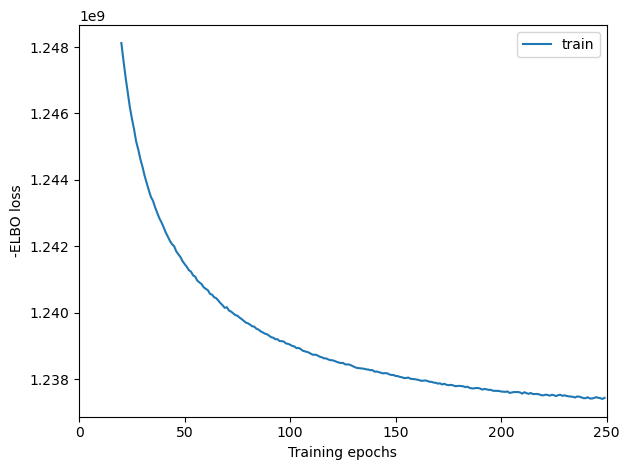

In [14]:
model2wo.plot_history(20)

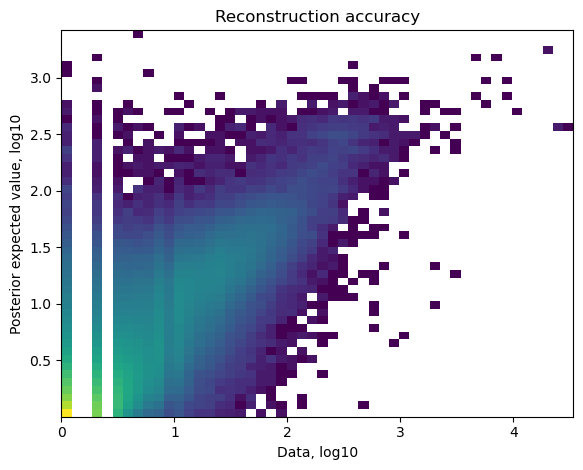

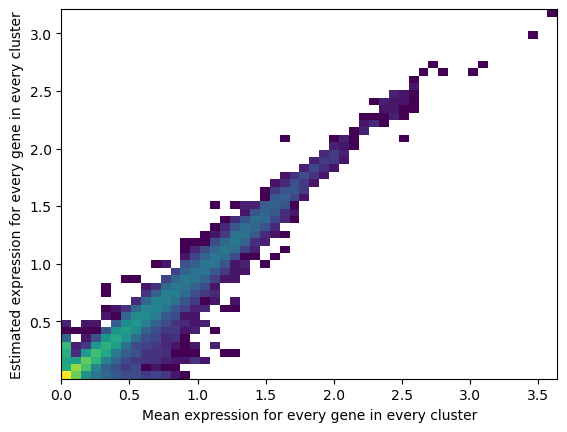

In [15]:
model2wo.plot_QC()

In [16]:
# Extracting reference cell types signatures as a pd.DataFrame
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver

,B cell,CD4 T cell,CD8 T cell,Conventional dendritic cell 1,Conventional dendritic cell 2,EndoMT EC,Fibroblast,Fibromyocyte,HMOX1+ Macrophage,Inflammatory Macrophage,...,NK cell,Neutrophil,Other Macrophage,PLIN2+/TREM1+ Macrophage,Plasma cell,Plasmacytoid dendritic cell,Pro-Angiogenic EC,Smooth Muscle Cell,TREM2+/Foamy Macrophage,Undefined
original_gene_names,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.000220,0.000820,0.000041,0.056503,0.000608,0.423541,0.116750,0.079093,0.002533,0.001144,...,0.000215,0.000380,0.000208,0.001268,0.004136,0.000829,0.128829,0.044325,0.001182,0.006990
TNMD,0.000091,0.000016,0.000022,0.004508,0.000285,0.000802,0.000127,0.000108,0.000244,0.000320,...,0.000125,0.000347,0.000040,0.000873,0.000566,0.001250,0.001698,0.000058,0.000155,0.168182
DPM1,0.059707,0.084280,0.073378,0.295671,0.281715,0.221054,0.236682,0.202517,0.157607,0.184219,...,0.073575,0.003787,0.146331,0.289742,0.139062,0.234047,0.182630,0.144287,0.334567,0.183246
SCYL3,0.010573,0.018034,0.011729,0.020111,0.022158,0.029202,0.027966,0.024113,0.029737,0.024692,...,0.015643,0.002573,0.026910,0.022967,0.013448,0.080916,0.029961,0.016013,0.034814,0.019293
FGR,0.008551,0.000467,0.017736,0.647190,0.907900,0.099547,0.005456,0.001211,0.278571,0.764641,...,0.208218,0.213320,0.194977,1.018057,0.009425,0.013864,0.057460,0.000492,0.891479,0.150796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC253572.2,0.003167,0.000062,0.000048,0.032541,0.331711,0.000391,0.000148,0.000112,0.064098,0.231751,...,0.000271,0.000321,0.226801,0.280278,0.023203,0.325091,0.000139,0.000064,0.056892,0.044641
AC092803.4,0.000091,0.000040,0.000025,0.001582,0.014860,0.000166,0.000148,0.000260,0.010823,0.022364,...,0.000138,0.001085,0.013729,0.016851,0.000625,0.000613,0.000113,0.000103,0.005396,0.004713
AC093849.4,0.000158,0.000040,0.000038,0.002046,0.003980,0.002024,0.000259,0.000144,0.011378,0.011046,...,0.000246,0.000302,0.017890,0.004274,0.000621,0.000956,0.001487,0.000080,0.017519,0.004804
